In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
seed = 1

### Generate some data with $y$ = $1_{\{(a,b) | ab >= 0\}}(x_1, x_2)$ where $x_1$ and $x_2$ are Uniform(-1, 1) random variables. 
- We want to predict $y$ based on $x_1$ and $x_2$.
- Note that there is no seperating hyperplace here.
 - If we model $P(y = 1)$ to depends on $x_1$ and $x_2$ in a linear manner, for example $P(y = 1) = sigmoid(w_0x_1 + w_1x_2 + b)$ we can't recover $y$ very well if we classify based on a rule of the form $w_0x_1 + w_1x_2 + b >= \delta$ for some $\delta$.
 - You NEED nonlinearity to get a better estimate.

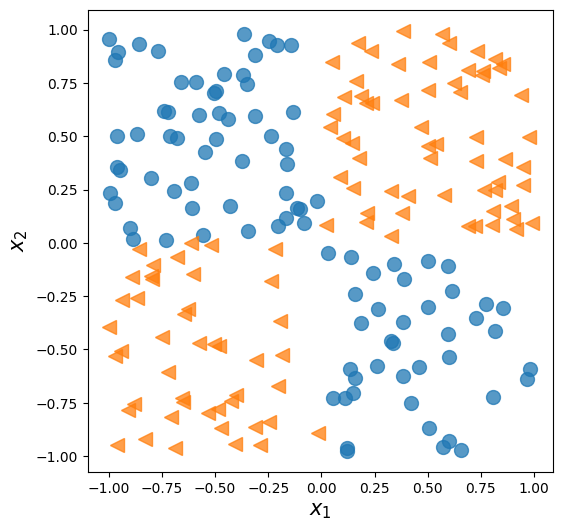

In [239]:
np.random.seed(seed)
torch.manual_seed(seed)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10, c='#1f77b4')
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10, c='#ff7f0e')
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

In [240]:
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=False)

### Try a linear model with nonlinearities. This is basically logistic regression.
- You split the full data set into small subsets (batches) and apply back propagation on this data over and over.
- You are given a small batch of data $(x, y)$ which is provided by the data loader above.
- $x$ is $N \times 2$ data, $N$ is the batch size.
- $z = W * x + b$ where W is nn.Linear(2, 1) and is a 2 $\times$ 1 matrix while $b$ is a 2 dimensional vector.
 - $z$ is $N \times 1$.
- a = $\sigma(z)$
 - $a$ is $N \times 1$.
- This function returns probabilities, $a$ are probabilities. $z$ are logits.

In [241]:
torch.manual_seed(seed)
model = nn.Sequential(
    nn.Linear(2, 1), # W and b from above live in here.
    nn.Sigmoid()
)

# nn.init.xavier_uniform_(model[0].weight)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [242]:
# What are the model parameters?
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

0.weight torch.Size([1, 2]) True
0.bias torch.Size([1]) True


In [243]:
# Look into PyTorch Lightening if you want less explicit code like this. Kind of like Keras.
torch.manual_seed(seed)
num_epochs = 200

# Log every 25 batches.
log_interval_grad = 50 

def train(model, num_epochs, train_dl, x_valid, y_valid, lr=0.001, loss_fn=nn.BCELoss, print_parameters=False, print_grads = False):
    loss_fn = loss_fn()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        # x_batch, y_batch are (x, y) above.
        for i, (x_batch, y_batch) in enumerate(train_dl):
            # So you get the right dimension.
            # You can also so p_hat = model(x_batch).squeeze() here.
            p_hat = model(x_batch)[:, 0]
            loss = loss_fn(p_hat, y_batch)
            loss.backward()
            optimizer.step()
                        
            # Do some sort of debugging analysis?
            # Are your gradients zero on average? 
            # Are they the right scale?
            if i+1 == log_interval_grad and print_grads:
                param_scale = 0.0
                grad_scale = 0.0
                total_grads = 0
                zero_grads = 0
                
                for _, param in model.named_parameters():
                    # .ravel() flattens a tensor.
                    param_scale += np.linalg.norm(param.data.ravel())
                    grad_scale += np.linalg.norm(lr * param.grad.ravel())
                    total_grads += len(param.grad.ravel())
                    zero_grads += sum(param.grad.ravel() == 0.0).item()
                    
                    # Maybe you want to print some of the parameters?
                    if print_parameters:
                        print(param.grad.ravel())
                        print(param.data.ravel())
                
                # Ideally, the ratio is around 0.001 or so.
                print("The ratio of data to grads is: {}".format(grad_scale / param_scale))
                
                # What percentage of parmaters have zero gradient?
                print("The percentage of zero grads is: {}".format(zero_grads / total_grads))
                 
            
            optimizer.zero_grad()
            
            
            loss_hist_train[epoch] += loss.item()
            is_correct = ((p_hat>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [244]:
history = train(model, num_epochs, train_dl, x_valid, y_valid, lr = 0.001)

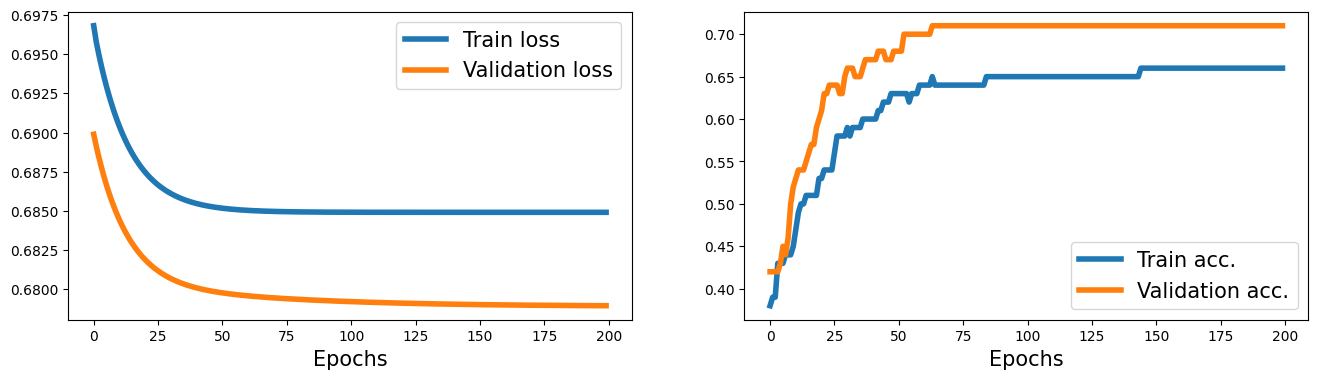

In [245]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
plt.show()

### Try a model with nonlinearities.
- You split the full data set into small subsets (batches) and apply back propagation on this data over and over.
- You are given a small batch of data $(x, y)$ which is provided by the data loader above.
- $x$ is $N \times 2$ data, $N$ is the batch size.
- $z = W * x + b$ where W is nn.Linear(2, 4) and is a $2 \times 4$ matrix while $b$ is a 4 dimensional vector.
 - $z$ is $N \times 4$.
- a = $ReLU(z)$
 - $a$ is $N \times 4$.
- You again do $z = W * a + b$ where W is nn.Linear(4, 1) and is a $4 \times 1$ matrix while $b$ is a 1 dimensional vector.
 - $z$ is $N \times 1$.
- a = $\sigma(z)$
 - $a$ is $N \times 1$.

In [246]:
torch.manual_seed(seed)
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

# Initialize parameters!
nn.init.xavier_uniform_(model[0].weight)
nn.init.xavier_uniform_(model[2].weight)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)

In [247]:
torch.manual_seed(seed)
history = train(model, num_epochs, train_dl, x_valid, y_valid, lr = 0.015)

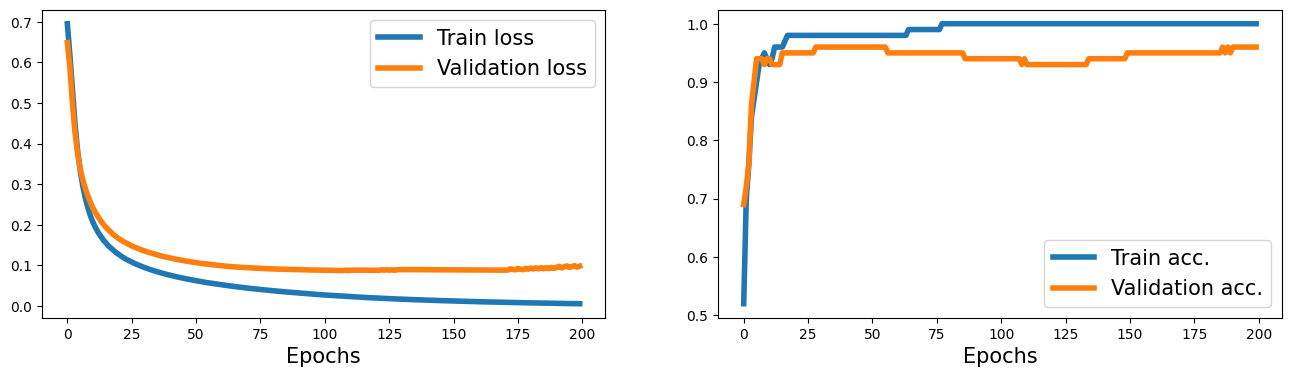

In [248]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
plt.show()

In [249]:
torch.manual_seed(seed)
# Same thing as above except now you wrap it in a nn.Module.
class MultilayerPerceptron1(nn.Module):
    def __init__(self):
        super().__init__()
        self.module_list = nn.ModuleList([
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        ])
        
        self._init()
        
    def _init(self):
        nn.init.xavier_uniform_(self.module_list[0].weight)
        nn.init.xavier_uniform_(self.module_list[2].weight)

    def forward(self, x):
        for layer in self.module_list:
            x = layer(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

# Deeper model -> vanishing gradients?
model = MultilayerPerceptron1()
model

MultilayerPerceptron1(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

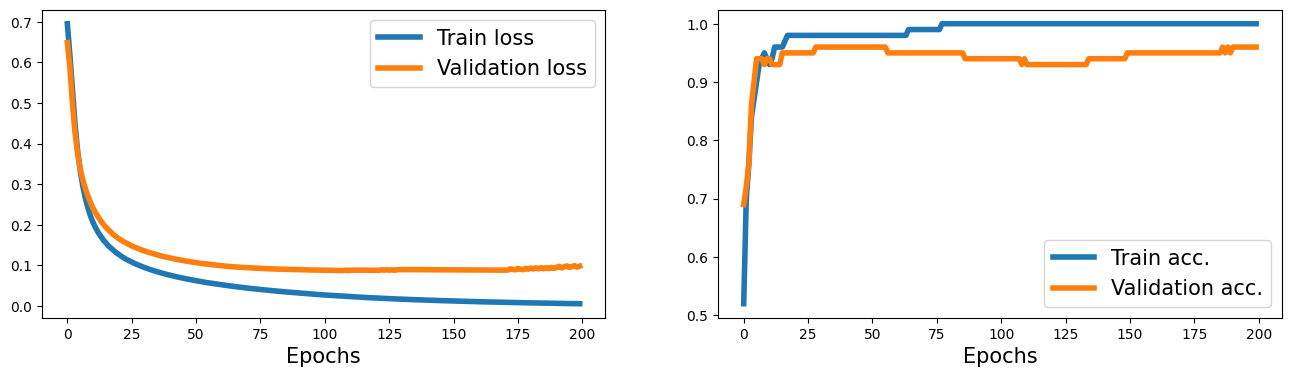

In [250]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
plt.show()

### Using Model.nn to make the model more flexible.
- Here there are 2 nonlinear laayers and the model is "deeper".
- Maybe it fits better? Maybe it actually over trains more? Either way, the recipe to built it is the same.

In [251]:
torch.manual_seed(seed)
class MultilayerPerceptron1(nn.Module):
    def __init__(self):
        super().__init__()
        self.module_list = nn.ModuleList([
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        ])

    def forward(self, x):
        for layer in self.module_list:
            x = layer(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

# Deeper model -> vanishing gradients?
model = MultilayerPerceptron1()
model

MultilayerPerceptron1(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [252]:
torch.manual_seed(seed)
history = train(model, num_epochs, train_dl, x_valid, y_valid, lr=0.01, print_parameters=True)

Try this if you want to look at the decision boundry: https://medium.com/data-science-community-srm/mlxtend-af073ebd0c51

You'll need to do: !pip install mlxtend

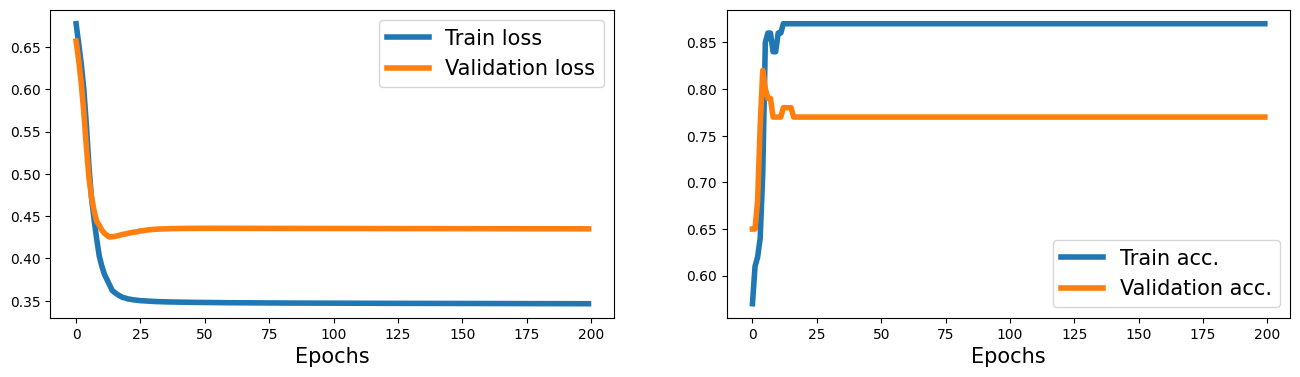

In [253]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
plt.show()

### Visualize this further.

In [143]:
def plot_intermediate_representations(
    model,
    x_train,
    y_train,
    plot_title,
    figsize=(10,2)
):
    y_pred = model(x_train).detach().numpy()

    x_train = x_train.numpy()
    y_train = y_train.numpy()

    colors = ['blue', 'red'] 
    markers = ['o', '<'] 

    plot_markers = []
    class_zero_indices = []
    class_one_indices = []
    for i in range(y_train.shape[0]):
        if y_train[i] == 0:
            class_zero_indices.append(i)
        else:
            class_one_indices.append(i)
    class_zero_indices = np.array(class_zero_indices)
    class_one_indices = np.array(class_one_indices)
    
    color_map = {
        0 : '#1f77b4',
        1 : '#ff7f0e'
    }

    fig, axes = plt.subplots(1, len(model.last_forward_cache), figsize=figsize)

    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):

        axes[0].scatter(
            x_train[data_indices, 0],
            x_train[data_indices, 1],
            edgecolor='black',
            facecolor="white",
            c=color_map[class_index], 
            marker=markers[class_index],
            s=[200,400][class_index]
        )
        axes[0].axis('off')
        for i, activations in enumerate(model.last_forward_cache[1:], 1):
            axes[i].scatter(
                activations[data_indices, 0],
                activations[data_indices, 1],
                edgecolor='black',
                facecolor="white",
                c=color_map[class_index],
                marker=markers[class_index],
                s=[200,400][class_index]
            )
            axes[i].axis('off')
            
    plt.tight_layout()

    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

In [144]:
class MultilayerPerceptron2(nn.Module):
    """
    """
    def __init__(
        self,
        input_size=2,
        hidden_size=2,
        output_size=2, 
        num_hidden_layers=1,
        hidden_activation=nn.Sigmoid
    ):
        """
        Initialize weights.

        Args:
            input_size (int): size of the input 
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron2, self).__init__()
        self.module_list = nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = hidden_size
        
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
            
        self.fc_final = nn.Linear(interim_input_size, output_size)
        
        self.last_forward_cache = []
       
    def forward(self, x):
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())
                    
        return nn.Softmax(dim=1)(output)

In [154]:
input_size = 2
output_size = 2
# If num_hidden_layers is 0, then effectively we do not have a neural network.
# If num_hidden_layers > 0, we seem to be able to seperate the data.
num_hidden_layers = 2
hidden_size = 2

torch.manual_seed(1)
np.random.seed(1)

model = MultilayerPerceptron2(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_hidden_layers=num_hidden_layers, 
    output_size=output_size
)

In [155]:
history = train(model, num_epochs, train_dl, x_valid, y_valid, lr=0.015, loss_fn=nn.CrossEntropyLoss)

The ratio of data to grads is: 2.0999505845659217e-10
The percentage of zero grads is: 0.0
The ratio of data to grads is: 9.06422623050638e-08
The percentage of zero grads is: 0.0
The ratio of data to grads is: 3.209267414782117e-06
The percentage of zero grads is: 0.0
The ratio of data to grads is: 2.2443344658545087e-05
The percentage of zero grads is: 0.0
The ratio of data to grads is: 7.305033414418258e-05
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.000151487824732185
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0002631179786554959
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.00039850636836611536
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0004953986494614681
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0005118111029951924
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.00048174896424014004
The percentage of zero grads is: 0.0
The rati

The ratio of data to grads is: 0.00047626474894146235
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0004844638922417058
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0004932839511354421
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0005028090395247233
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.000513134473971123
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0005243596137953801
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0005365943132681123
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0005499465458176338
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0005645105334487284
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0005803400974900392
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0005974065807158129
The percentage of zero grads is: 0.0
The ratio 

The ratio of data to grads is: 0.00027994697792075413
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0002771556188198029
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.00027436237522228564
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.00027157388370188104
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.0002687895656384983
The percentage of zero grads is: 0.0
The ratio of data to grads is: 0.00026601397684457214
The percentage of zero grads is: 0.0


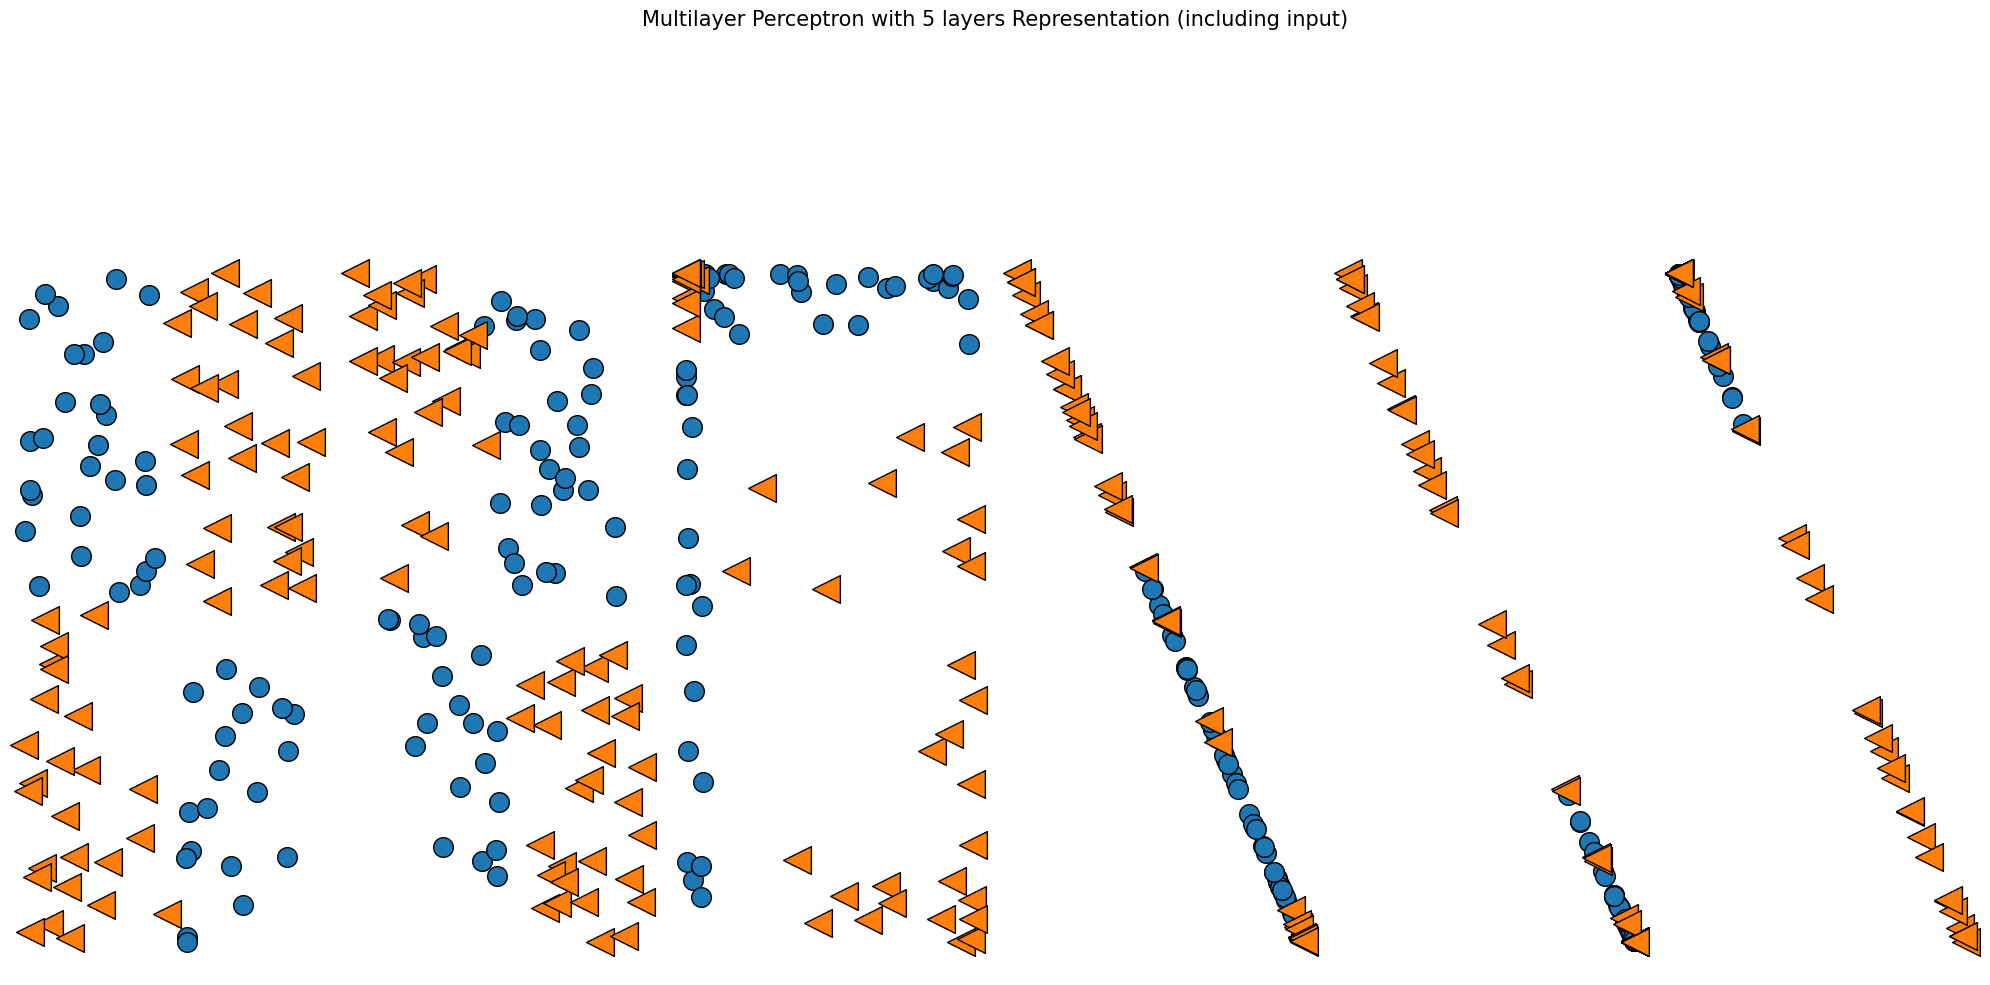

In [156]:
plot_intermediate_representations(
    model,
    x_train,
    y_train,
    "Multilayer Perceptron with {} layers Representation (including input)".format(len(model.module_list) + 1),
    figsize=(20, 10)
)